# Experimento 1
***
- Conjuntos de dados: Shenzen
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importando os pacotes necessários

In [73]:
import glob
import re
from tqdm import tqdm
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### Pré-processando os dados

In [39]:
# coletando o caminho dos arquivos dos dados do hospital shenzen
filelist_shenzen = glob.glob('/content/drive/MyDrive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')

In [40]:
# quantidade de imagens disponíveis no dataset
print('quantidade de imagens:', str(len(filelist_shenzen)))

quantidade de imagens: 662


In [41]:
def extract_label(file_list):
    
    # inicializando uma lista vazia
    labels = []
    
    # iterando na lista de arquivos
    for file in tqdm(file_list):
        # detectando as classes presentes no nome da imagem
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        # adicionando a lista de rótulos as classes correspondentes a cada uma das imagens
        labels.append(current_label[0])
        
    return labels

In [42]:
# extraindo os rótulos
labels = extract_label(filelist_shenzen)

100%|██████████| 662/662 [00:00<00:00, 235567.09it/s]


In [43]:
# visualizando a quantidade de rótulos
print('quantidade de rótulos:', str(len(labels)))

quantidade de rótulos: 662


In [44]:
# criando um dataframe com os caminhos das imagens
full_data = pd.DataFrame(filelist_shenzen, columns = ['filepath'])
# adicionando os rótulos em cada imagem
full_data['target'] = labels

In [45]:
# modificando o formato dos dados para float32
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type)

In [46]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [47]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [48]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 423
quantidade de rótulos de treinamento: 423
quantidade de imagens de teste: 133
quantidade de rótulos de teste: 133
quantidade de imagens de validação: 106
quantidade de rótulos de validação: 106


### Aplicando mudança de escala típica

In [49]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(rescale = 1./255., rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      color_mode = 'rgb',
                                                      target_size = (256, 256))
# criando o gerador de imagens de validação 
valid_generator = image_generator.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (256, 256))

# normalizando as imagens de teste 
test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'raw',
                                                  target_size = (256, 256))

Found 423 validated image filenames.
Found 106 validated image filenames.
Found 133 validated image filenames.


### Preparando a rede neural convolucional

In [50]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-02 20:44:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   141MB/s    in 0.6s    

2021-03-02 20:44:39 (141 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [51]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# visualizando a arquitetura definida
pre_trained_model.summary()

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 127, 127, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 127, 127, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [52]:
# definindo uma camada de achatamento
x = layers.Flatten()(last_output)
# conecatando a rede uma camada com 1024 neurônios e função de ativação relu
x = layers.Dense(units = 1024, activation = 'relu')(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 512, activation = 'relu')(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)                  
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 1, activation = 'sigmoid')(x)           

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', 
              metrics = ['acc']) 

In [53]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [54]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [57]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 423  // 32, 
                              validation_data = valid_generator, validation_steps = 106 // 32,
                              callbacks = callbacks, epochs = 100)

Epoch 1/100
13/13 [==============================] - 370s 28s/step - loss: 1.2329 - acc: 0.5582 - val_loss: 0.5002 - val_acc: 0.7500

Epoch 00001: val_acc improved from -inf to 0.75000, saving model to transferlearning_weights.hdf5
Epoch 2/100
13/13 [==============================] - 84s 7s/step - loss: 0.5805 - acc: 0.7394 - val_loss: 0.4132 - val_acc: 0.8229

Epoch 00002: val_acc improved from 0.75000 to 0.82292, saving model to transferlearning_weights.hdf5
Epoch 3/100
13/13 [==============================] - 75s 6s/step - loss: 0.3808 - acc: 0.8396 - val_loss: 0.5802 - val_acc: 0.7188

Epoch 00003: val_acc did not improve from 0.82292
Epoch 4/100
13/13 [==============================] - 51s 4s/step - loss: 0.4062 - acc: 0.8217 - val_loss: 0.5415 - val_acc: 0.7604

Epoch 00004: val_acc did not improve from 0.82292
Epoch 5/100
13/13 [==============================] - 51s 4s/step - loss: 0.3805 - acc: 0.8219 - val_loss: 0.5090 - val_acc: 0.7917

Epoch 00005: val_acc did not improve fr

In [58]:
model.evaluate(test_generator)

5/5 [==============================] - 88s 21s/step - loss: 1.7678 - acc: 0.8571


[1.7677589654922485, 0.8571428656578064]

In [59]:
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [60]:
best_model.evaluate(test_generator)

5/5 [==============================] - 13s 2s/step - loss: 1.5337 - acc: 0.8647


[1.5337355136871338, 0.8646616339683533]

In [71]:
(x1, y1) = test_generator[0]
(x2, y2) = test_generator[1]
(x3, y3) = test_generator[2]
(x4, y4) = test_generator[3]
(x5, y5) = test_generator[4]

In [76]:
x = np.concatenate((x1, x2, x3, x4, x5))
y = np.concatenate((y1, y2, y3, y4, y5))

In [77]:
predict = best_model.predict(x)

In [78]:
predict

array([[5.2208062e-03],
       [1.7564675e-02],
       [2.3706079e-02],
       [4.4439593e-01],
       [9.9995804e-01],
       [1.0000000e+00],
       [2.8992530e-30],
       [1.0127876e-05],
       [9.9881113e-01],
       [1.4176417e-05],
       [7.8398829e-21],
       [1.3247133e-05],
       [5.1180258e-11],
       [9.9997890e-01],
       [9.9999750e-01],
       [9.9874949e-01],
       [5.6465890e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.0225481e-13],
       [9.9999976e-01],
       [1.0000000e+00],
       [4.6603105e-29],
       [1.3956423e-08],
       [9.6726034e-17],
       [9.9999881e-01],
       [3.8301281e-17],
       [7.4556229e-11],
       [1.0000000e+00],
       [2.5648606e-06],
       [3.9916487e-31],
       [3.5382461e-04],
       [9.9999976e-01],
       [1.3242317e-11],
       [1.0000000e+00],
       [9.9995482e-01],
       [2.2994489e-09],
       [3.8686110e-07],
       [1.0000000e+00],
       [6.9650860e-06],
       [1.000000

In [79]:
y

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [80]:
predict_ = []
for i in predict:
  if i > 0.95:
    predict_.append(1)
  else:
    predict_.append(0)

In [81]:
confusion_matrix(predict_, y)

array([[58, 12],
       [ 7, 56]])

In [82]:
precision_recall_fscore_support(predict_, y)

(array([0.89230769, 0.82352941]),
 array([0.82857143, 0.88888889]),
 array([0.85925926, 0.85496183]),
 array([70, 63]))

In [83]:
precision = 58 / (58 + 12)
precision

0.8285714285714286

In [84]:
recall = 58 / (58 + 7)
recall

0.8923076923076924

In [85]:
f1 = (2 * precision * recall) / (precision + recall)
f1

0.8592592592592593

In [86]:
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


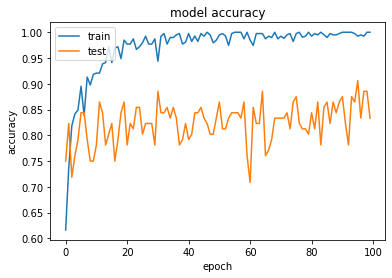

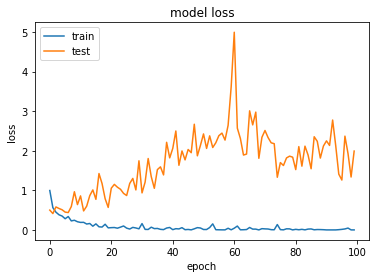

<Figure size 432x288 with 0 Axes>

In [87]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')